## Load/import packages

In [37]:
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers

%matplotlib inline
# Import from features, labels and reshaper function
from load_features import (
    train_features,
    val_features,
    train_labels,
    val_labels,
    reshaper,
)


# Check if Tensorflow uses GPU
print(tf.config.experimental.list_physical_devices("GPU"))

# Limit GPU memory usage
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print()
print(f"Tensorflow Version: {tf.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Keras Version: {tf.keras.__version__}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Tensorflow Version: 2.4.0-rc0
Numpy Version: 1.19.2
Keras Version: 2.4.0


In [2]:
print(reshaper.__doc__)


    :param features: extracted image features
    :type features: scipy CSR matrix (2-Dim)
    :param labels: one-hot encoded labels of each image
    :type labels: numpy array (2-Dim)
    :param sequence_length: the length of the sequence you want. E.g. You want 25 images in a seqeunce so, value is 25
    :type sequence_length: int
    
    


# Prepare data

In [3]:
seq_train_features, seq_train_labels = reshaper(train_features, train_labels, 60)
seq_val_features, seq_val_labels = reshaper(val_features, val_labels, 60)

In [28]:
from sklearn.utils import class_weight

In [29]:
y_integers = np.argmax(seq_train_labels, axis=2)
class_weights = class_weight.compute_class_weight(
    "balanced", np.unique(y_integers), y_integers.flatten()
)
d_class_weights = dict(enumerate(class_weights))

In [30]:
arr = y_integers.copy()
def rec(array, start=0):
    labels = d_class_weights.keys()
    labels = list(labels)
    if start > 6:
        return array
    array = np.where(array==labels[start], d_class_weights.get(labels[start]), array)
    
    return rec(array, start+1)

In [31]:
test = rec(arr)

# Build model

In [75]:
# Best model till now!
def build_model(inp_shape):
    model = Sequential(name="RNN-LSTM")
    model.add(
        layers.LSTM(64, input_shape=inp_shape, return_sequences=True, name="LSTM_1")
    )
    model.add(layers.LayerNormalization())
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(optimizer="adagrad", loss="categorical_crossentropy", metrics=["acc",'AUC'])
    return model

In [76]:
inp_shape = (seq_train_features.shape[1], seq_train_features.shape[2])
cnn_rnn_LSTM = build_model(inp_shape)
cnn_rnn_LSTM.summary()

Model: "RNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 60, 64)            1196288   
_________________________________________________________________
layer_normalization_10 (Laye (None, 60, 64)            128       
_________________________________________________________________
Dense_Output (Dense)         (None, 60, 7)             455       
Total params: 1,196,871
Trainable params: 1,196,871
Non-trainable params: 0
_________________________________________________________________


# Train + Evaluate model

In [ ]:
# AW2_norm_minitrain = AW2_norm_minitrain.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
history = cnn_rnn_LSTM.fit(
    seq_train_features,
    seq_train_labels,
    sample_weight=test,
    validation_data=(seq_val_features, seq_val_labels),
    epochs=50,
    verbose=1,
)

Epoch 1/50
481/481 [==============================] - 13s 24ms/step - loss: 1.7854 - acc: 0.3397 - auc: 0.7036 - val_loss: 1.9440 - val_acc: 0.3054 - val_auc: 0.6632
Epoch 2/50
481/481 [==============================] - 11s 23ms/step - loss: 1.1387 - acc: 0.5168 - auc: 0.8421 - val_loss: 1.8483 - val_acc: 0.3406 - val_auc: 0.7007
Epoch 3/50
481/481 [==============================] - 11s 23ms/step - loss: 0.9605 - acc: 0.5847 - auc: 0.8827 - val_loss: 1.8233 - val_acc: 0.3512 - val_auc: 0.7127
Epoch 4/50
481/481 [==============================] - 11s 23ms/step - loss: 0.8168 - acc: 0.6231 - auc: 0.9042 - val_loss: 1.7772 - val_acc: 0.3676 - val_auc: 0.7305
Epoch 5/50
481/481 [==============================] - 11s 22ms/step - loss: 0.7733 - acc: 0.6471 - auc: 0.9157 - val_loss: 1.7666 - val_acc: 0.3712 - val_auc: 0.7356
Epoch 6/50
481/481 [==============================] - 11s 22ms/step - loss: 0.7270 - acc: 0.6672 - auc: 0.9248 - val_loss: 1.7695 - val_acc: 0.3726 - val_auc: 0.7380
Epoc

In [61]:
def plot_history(data_list, label_list, title, ylabel):

    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

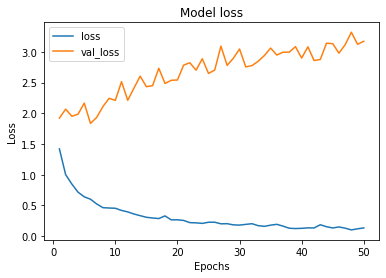

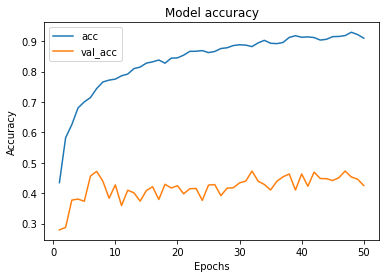

In [62]:
model_hist = history.history

data_list1 = [model_hist["loss"], model_hist["val_loss"]]
data_list2 = [model_hist["acc"], model_hist["val_acc"]]
labels = [*model_hist.keys()]

title1 = "Model loss"
title2 = "Model accuracy"
y_label1 = "Loss"
y_label2 = "Accuracy"

plot_history(data_list1, [labels[0], labels[3]], title1, y_label1)
plot_history(data_list2, [labels[1], labels[4]], title2, y_label2)

# Predict on test set
1. Create loop which reads feature_data from each video directory
2. Predict on these features
3. Write predictions to filename.txt